In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras import initializers, regularizers

from sklearn.preprocessing import StandardScaler


10000


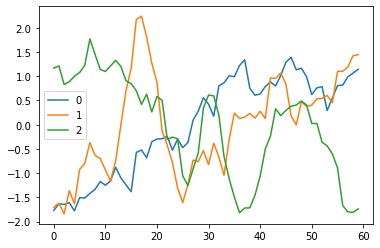

In [2]:
str0 = "ts_L60_Z12_A500_DX50_bias5_N10000"

fnamex = "DATA/x_"+str0+".csv"
fnamey = "DATA/y_"+str0+".csv"

x = np.asarray(pd.read_csv(fnamex, header = None))

N = len(x)
print(N)

scaler = StandardScaler()
x_std =  scaler.fit_transform(x.T).T

plt.plot(x_std[0], label = '0')
plt.plot(x_std[1], label = '1')
plt.plot(x_std[2], label = '2')
plt.legend()
plt.show() 

In [3]:
categ  = np.asarray(pd.read_csv(fnamey, header = None), dtype = int)
N_categ = 3
y = np.zeros((N,N_categ))

for n in range(N):
    y[n][categ[n]] = 1.
    
print(y[0])

[1. 0. 0.]


## Data splitting


In [4]:
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N-N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]


L = len(x[0])
print(N, N_train, N_val, L)

10000 8000 2000 60


## Data reshaping

In [5]:
x_train = x_train.reshape(x_train.shape[0],L,1) #1 - channel (RGB:3)
                                                # L = sample size
x_val = x_val.reshape(x_val.shape[0],L,1)

input_shape = (L,1)

# CNN definition


In [6]:
np.random.seed(12345)

reg = regularizers.l2(0.01) #Lasso

ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()
#kernel_size = 11... similar to 12 as before
model.add(Conv1D( filters = 5, kernel_size = 11, kernel_regularizer = reg, 
                 kernel_initializer = ini, 
                 activation = "relu", 
                 input_shape = input_shape                
                ))
model.add(MaxPooling1D(5))
model.add(Conv1D(filters = 5, kernel_size = 7, 
                 activation = "relu", 
                ))
model.add(MaxPooling1D(2)) #optional
model.add(Flatten())
model.add(Dense(10, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(N_categ, activation = "softmax"))

model.summary()

model.compile(loss = keras.losses.categorical_crossentropy, 
              optimizer = "adam", 
             metrics = ["accuracy"])

# model.save_weights("Original_Weights_CNN1.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0

Not Working!
The NN has as input larger and larger numbers. We shall manipulate the data at the beginning for example reshuffling them as they have average 0 and remove their standard deviation (set it to 1)


In [ ]:
hist = model.fit(x_train, y_train, batch_size = 250, epochs = 250, 
                 validation_data = (x_val, y_val), 
                verbose = 2, shuffle = True)

Epoch 1/250
32/32 - 3s - loss: 5411.8525 - accuracy: 0.3320 - val_loss: 1.0998 - val_accuracy: 0.3335
Epoch 2/250
32/32 - 0s - loss: 1.0996 - accuracy: 0.3334 - val_loss: 1.0994 - val_accuracy: 0.3335
Epoch 3/250


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(categ[N_train:],np.argmax(model.predict(x_val), axis=1),  normalize = 'true')


#Better visualization of confusion matrices
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (15, 8))
ax1.matshow(c_matrix, cmap = plt.cm.YlGn, alpha = 0.5)
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
for i in range(3):
    for j in range(3):
        ax1.text(x=j, y=i, s=round(c_matrix[i, j],2), ha="center", va="center")
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlabel('predicted label')
ax1.set_ylabel('true label')
ax1.set_title('CNN')
fig.tight_layout()
plt.show()

## Test Discrimination loss

In [ ]:
As = np.linspace(50,500,10)
res = []

for A in As[-3:]:
    str0 = f"ts_L60_Z12_A{A}_DX50_bias5_N10000"
    fnamex = "DATA/x_" + str0 + ".csv"
    fnamey = "DATA/y_" + str0 + ".csv"
    
    x = np.asarray(pd.read_csv(fnamex, header = None))

    scaler = StandardScaler()
    x_std =  scaler.fit_transform(x.T).T
    categ  = np.asarray(pd.read_csv(fnamey, header = None), dtype = int)
    N_categ = 3
    y = np.zeros((N,N_categ))

    for n in range(N):
        y[n][categ[n]] = 1.

    perc_train = 0.8
    N_train = int(N*perc_train)
    N_val = N-N_train

    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]


    L = len(x[0])
    x_train = x_train.reshape(x_train.shape[0],L,1) #1 - channel (RGB:3)
                                                   # L = sample size
    x_val = x_val.reshape(x_val.shape[0],L,1)

    input_shape = (L,1)
    
#     model.load_weights("Original_Weights_CNN1.h5")
    hist = model.fit(x_train, y_train, batch_size = 250, epochs = 50, 
                 validation_data = (x_val, y_val), 
                verbose = 2, shuffle = True)
    res.append(pd.DataFrame(hist))
    


In [ ]:
pd.DataFrame(hist)